In [1]:
from load_data import get_all_video_ids, load_video_files, load_embedding_values, load_embedding_files, load_key_video_files, load_keyframe_embedding_files
from segment_processing import get_segmented_frames_and_embeddings, get_video_duration
from embedding_surveyor import SlidingWindowAnalyzer
from fnEDA import *
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import configparser
import cv2
scatter_size = (9, 4)

def get_data(specific_videos=None):
    directory = read_config("directory")
    video_ids = get_all_video_ids(directory['originalframes'])
    if specific_videos is not None:
        video_ids = [vid for vid in video_ids if vid in specific_videos]
        
    video_files = load_video_files(video_ids, directory)
    key_video_files = load_key_video_files(video_ids, directory)
    embedding_values = load_embedding_values(load_embedding_files(video_ids, directory))
    key_embedding_values = load_embedding_values(load_keyframe_embedding_files(video_ids, directory))
    return video_files, key_video_files, embedding_values, key_embedding_values

video_files, key_video_files, embedding_values, key_embedding_values = get_data(specific_videos=[1])

# Get video duration
total_duration = get_video_duration(video_files)
# Set start and end indices
start_idx, end_idx = 0, 2500
# Get segmented original frames and embeddings
frame_embedding_pairs, segmented_embeddings = get_segmented_frames_and_embeddings(video_files, embedding_values, total_duration, start_idx, end_idx)
# Get segmented keyframes and embeddings
key_frame_embedding_pairs, key_segmented_embeddings = get_segmented_frames_and_embeddings(key_video_files, key_embedding_values, total_duration, 0, len(key_embedding_values))
print(f"Total frame-embedding pairs: {len(frame_embedding_pairs)}")
print(f"Total key frame-embedding pairs: {len(key_frame_embedding_pairs)}")

Duration of video 1: 332.64 seconds
Average Duration per Frame: 0.04 seconds
Average Duration per Embedding: 0.1331 seconds
____________________________________________________________________
Duration of video 1: 332.64 seconds
Average Duration per Frame: 4.2106 seconds
Average Duration per Embedding: 4.2646 seconds
____________________________________________________________________
Total frame-embedding pairs: 2499
Total key frame-embedding pairs: 78


## Evaluation EDA
This notebook provides reasoning and evaluation steps for the proposed method. 

##### ``1. Video Frames and Embeddings over Video duration in seconds with PCA``
###### Note: Original video embeddings size is set with start_idx and end_idx in cell 1

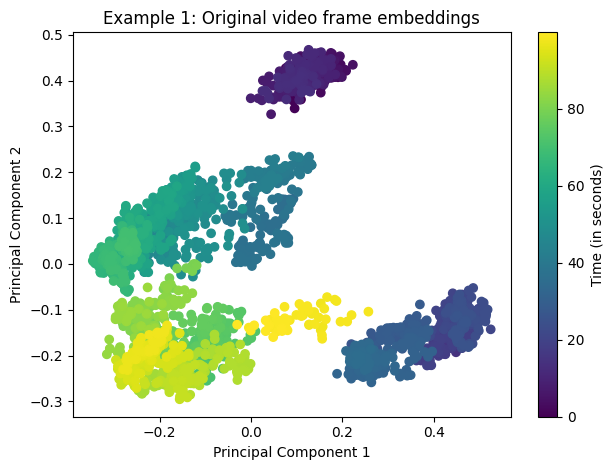

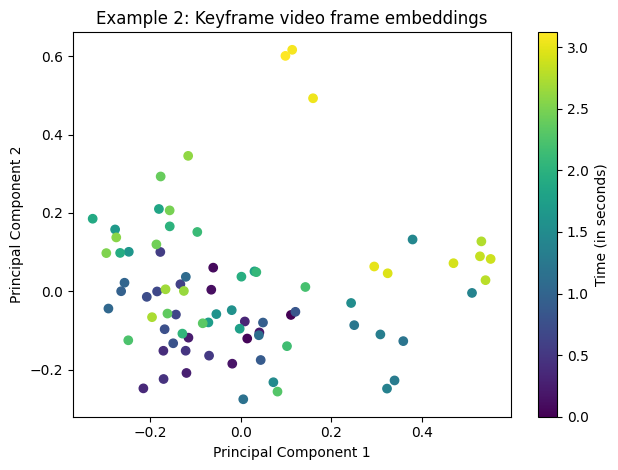

In [2]:
vid_cap, frame_rate = initialize_video(video_files[0])
view_pca_time(segmented_embeddings, key_embedding_values, frame_rate)

##### ``2. Visualize sample frames, embeddings, and similarities``
- **Successor Frame Similarity**: Green bars quantify the Euclidean distance between the embeddings of consecutive frames. The x-axis labels specify the frame index used for comparison. The y-axis quantifies the similarity; lower values signify higher similarity.
- **Embedding Vectors**: Red scatter points display embedding vector values. The `is_average` parameter toggles between displaying the average value of all dimensions (`True`) or the value of a specific dimension (`False`).
- **Multi-Dimensional View**: The function accommodates visualization of either averaged dimensions or a specific dimension, controlled by the `is_average` parameter.
- **Annotations**: Numerical values annotate each red scatter point, providing exact data for each embedding vector.
- **Dual Y-Axis**: The left y-axis corresponds to similarity values, while the right y-axis corresponds to embedding vectors.
#### Note: 
I'm further reducing the size of frame embeddings to get a view of different visuals. This is particularly useful when dealing with high-dimensional data, as it allows for easier interpretation and analysis.

#### Example 1: Visualization of the Original Video with Corresponding Embeddings and Similarities

<Figure size 1000x1000 with 0 Axes>

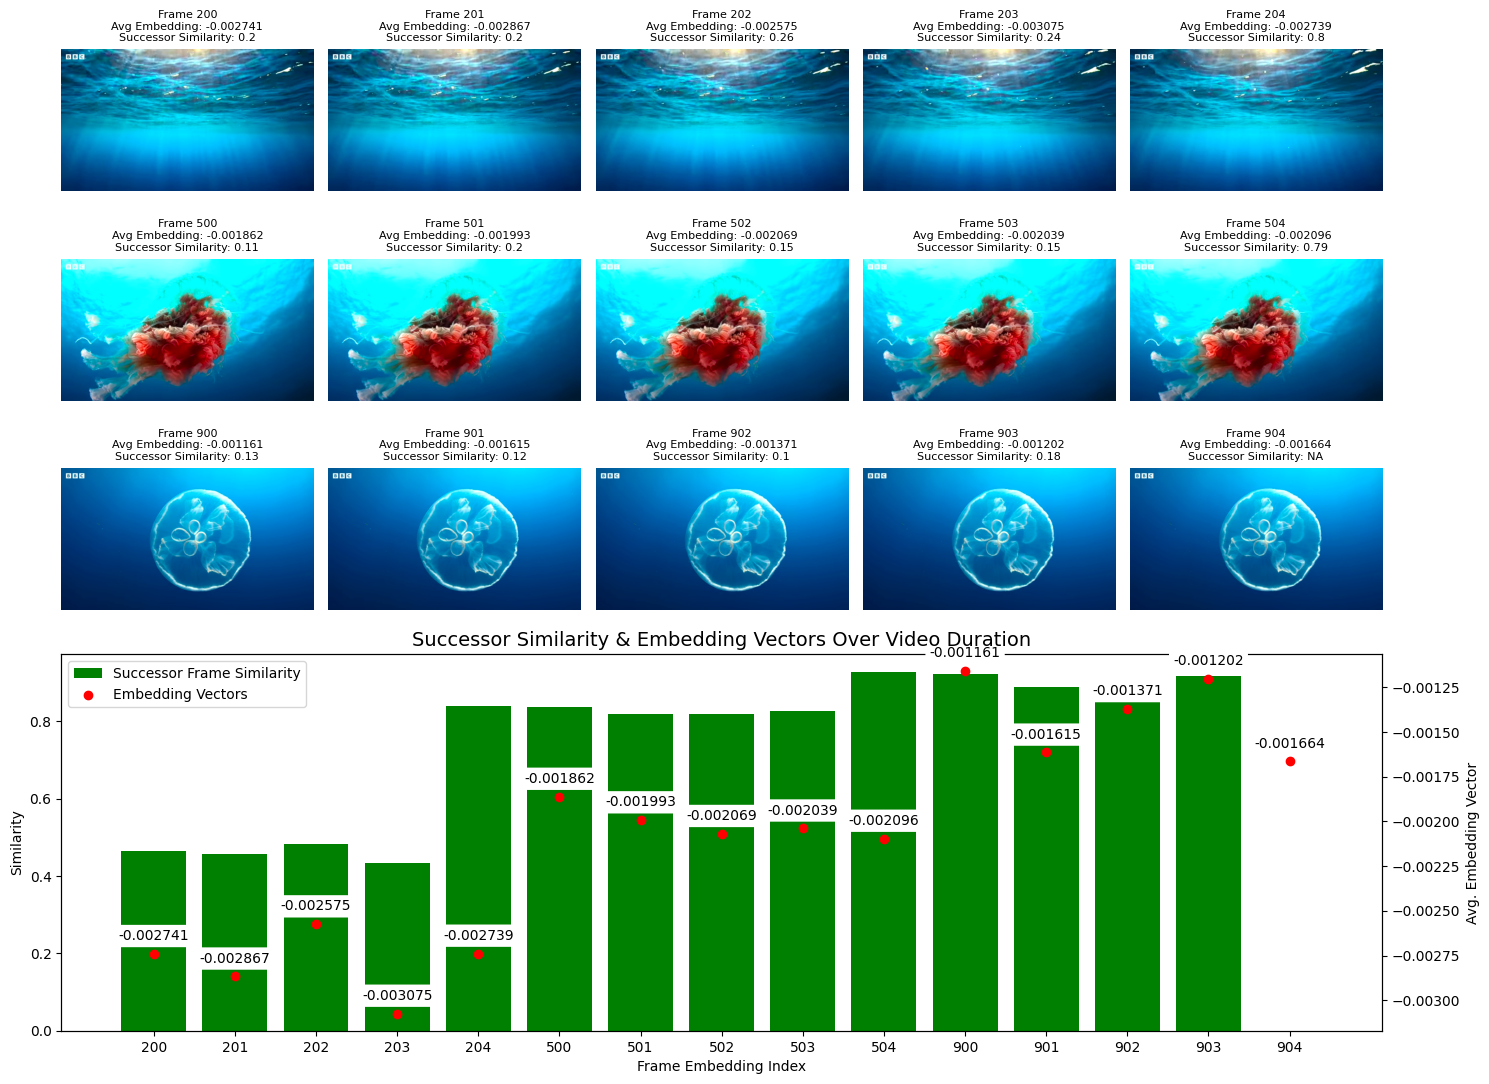

In [3]:
frame_indices_to_visualize = list(range(200, 205))  + list(range(500, 505)) + list(range(900, 905))
embedding_values = normalize(embedding_values, axis=1)
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(1, 1)
fig, gs = visualize_frames(vid_cap, frame_indices_to_visualize, embedding_values)
plot_embedding_and_similarity(fig, gs, frame_indices_to_visualize, embedding_values, True)

##### Example 2: Visualization of the Keyframe Video with Corresponding Embeddings and Similarities

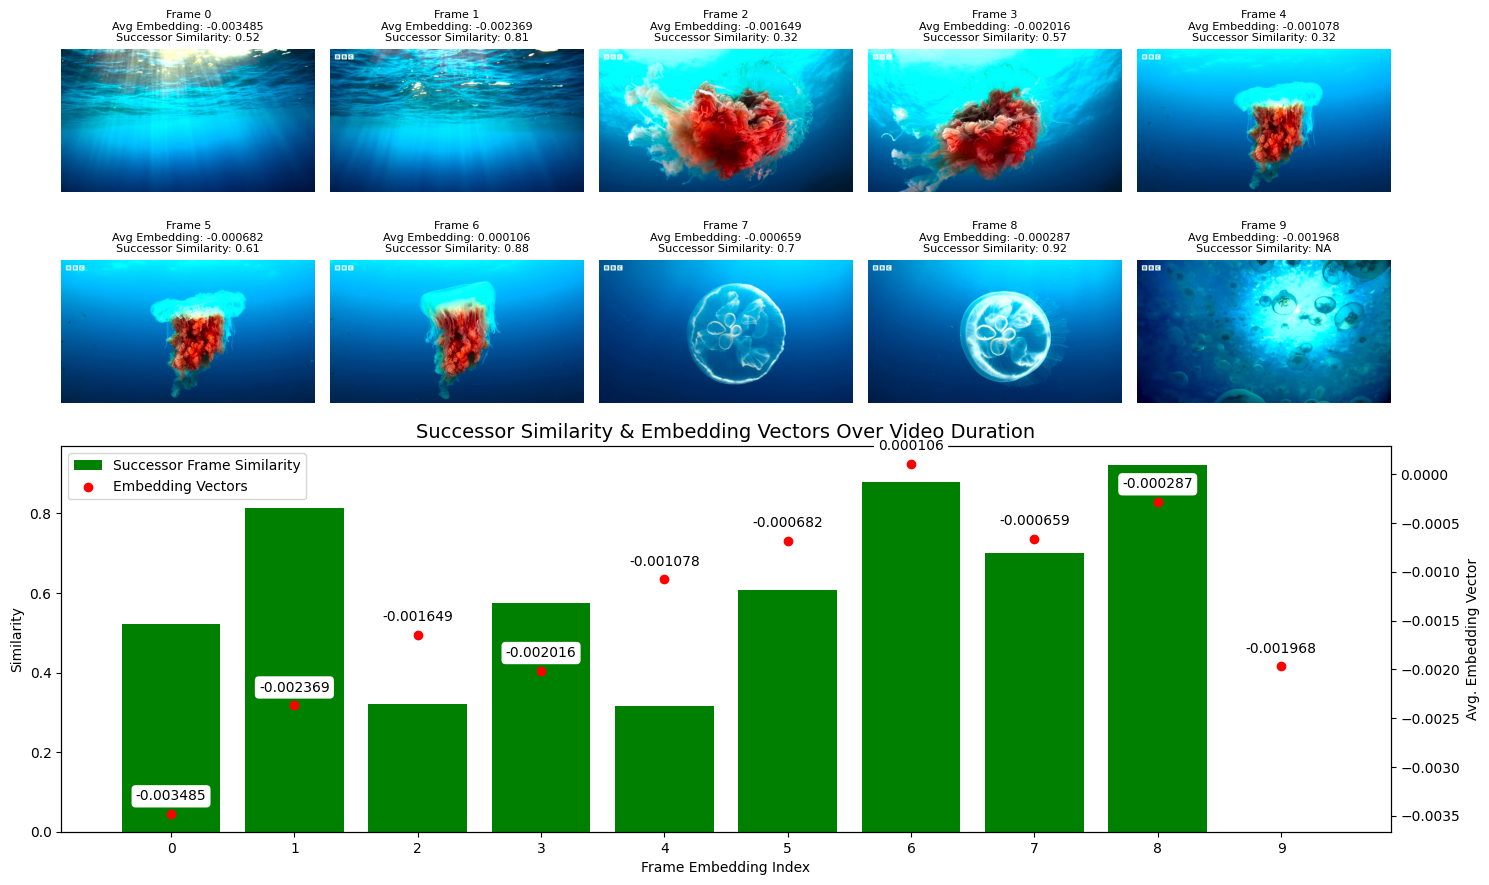

In [4]:
vid_cap, frame_rate = initialize_video(key_video_files[0])
frame_indices_to_visualize = list(range(0, 10))
fig, gs = visualize_frames(vid_cap, frame_indices_to_visualize, key_segmented_embeddings)
plot_embedding_and_similarity(fig,gs, frame_indices_to_visualize, key_segmented_embeddings, True)

##### ``3. Grouped Segmentation``
##### This section provides both a high-level overview and a detailed analysis of how embeddings cluster together. The idea is that frames will reorganize into natural groupings based on visual similarity, providing another perspective of score distributions. 
- **Fixed k-Value**:  
  The concern here is not to optimize the number of clusters (`k`),`k` value is sugis set to 6 K-Nearest Neighbors (KNN).
- **Sequence Counting**:  
  This feature counts the number of sequences within each KNN cluster. It associates this count with the cluster's centroid. The centroids are then sorted based on this count and their distance to the origin.
- **Frame Plotting**:  
  Plots individual frames related to each centroid. The frames are sorted based on their sequence count and proximity to the centroid.
- **Multiple Plots**:  
  Two types of visualizations are generated:
  1. t-SNE reduced embeddings along with their centroids.
  2. Individual frames associated with each centroid.
- **Additional Annotations**:  
  The scatter plot includes frame index, the sequence count for each centroid, and the distance to the centroid.
- **Cluster Centroid Sorting**:  
  The sorting of centroids is based on the number of sequences they contain and their distance to the origin.

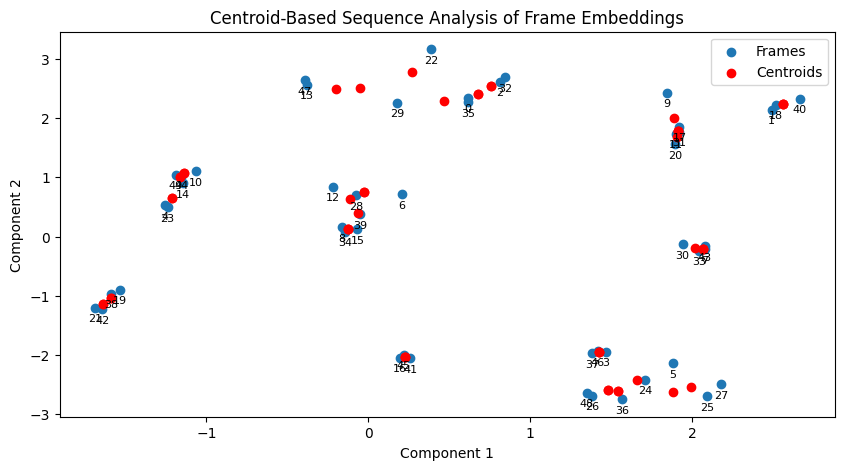

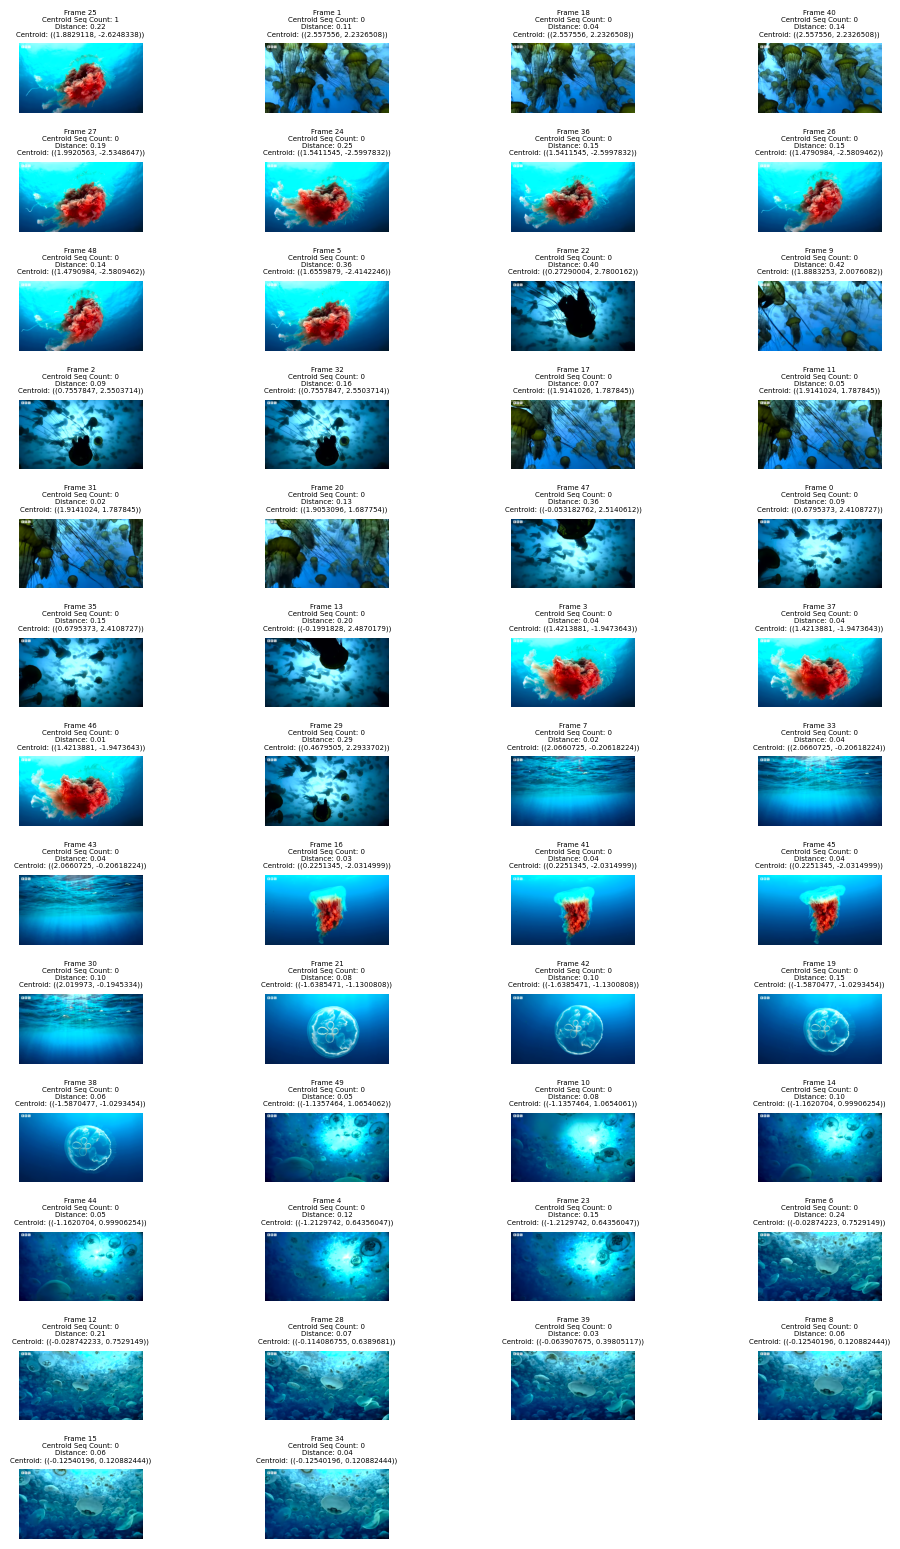

In [2]:
run_knn(3, segmented_embeddings, frame_embedding_pairs, num_samples=50)

##### ``4. Find Optimal k for KNN Clustering``
The goal is to identify the best `k` value that maximizes the number of *sequence segment* clusters. A *sequence segment* cluster is a special type of cluster where all the nearest neighbor indices form a sequence.
- **KNN Model Initialization**:  
  The K-Nearest Neighbors (KNN) model is initialized and fitted to the provided embeddings (`embedding_values`).
- **Iterative k-Value Search**:  
  The algorithm iterates through various `k` values to find the one that maximizes the number of sequence segment clusters. The performance of each `k` is stored in a list (`k_performance`).
- **Performance Visualization**:  
  A plot is generated to visualize the number of sequence segment clusters against the different `k` values. This helps in assessing the performance of each `k`.
- **Dimensionality Reduction with t-SNE**:  
  The optimal `k` value is then used for dimensionality reduction using t-SNE.
- **Scatter Plot with Annotations**:  
  The t-SNE reduced embeddings are plotted in a scatter plot. Each point is annotated with its distance to the centroid of its KNN cluster.
- **Optimal k-Value Usage**:  
  The code aims to find the `k` value that maximizes the number of sequence segment clusters. Once identified, this `k` is used for t-SNE dimensionality reduction and subsequent visualization.

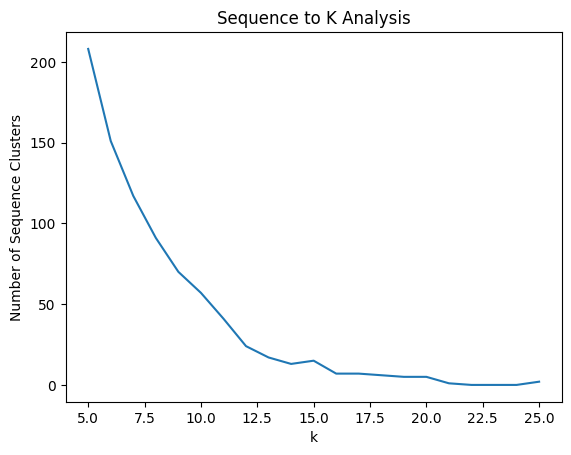

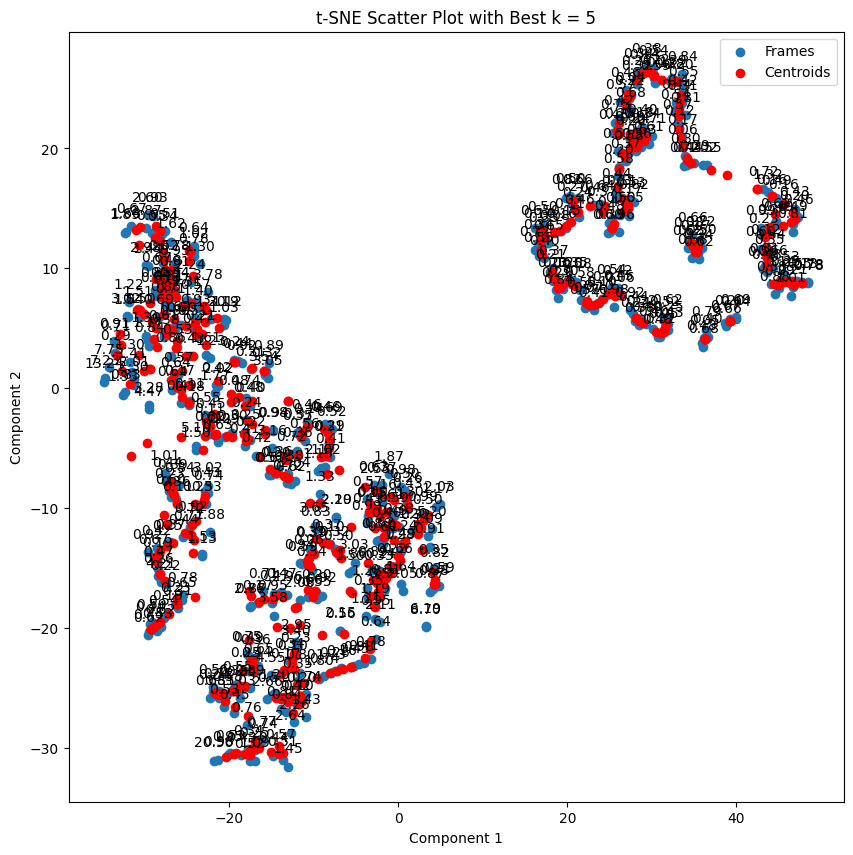

In [ ]:
clip_indices_to_visualize = list(range(0, 500)) + list(range(510, 520)) + list(range(750, 760))
run_optimized_knn(segmented_embeddings, clip_indices_to_visualize)

##### ``5. Dynamic Window Averaging``
This function serves as a fine-grained analysis tool that comes into play after preliminary segmentation and distance-based clustering have been performed on the video. It aims to visualize specific video clips based on their embeddings and to pinpoint potential visual transitions or anomalies.
- **Rolling Window & Frame Buffer**:  
  Initialize a rolling window for similarity scores and a frame buffer to store frames that meet specific criteria.
- **Embedding Similarity Calculation**:  
  Utilize Euclidean distance to compute the similarity between consecutive embeddings. This metric serves as a basis for identifying transitions or anomalies.
- **Dynamic Rolling Window Update**:  
  The rolling window is updated with each new similarity score. The window size can be dynamic, adapting to the complexity or uniformity of the video content.
- **Transition & Anomaly Detection**:  
  Evaluate if the current frame represents a significant change in visual content. This is determined by comparing its similarity score to a dynamically computed average within the rolling window.

The examples below illustrate the effectiveness of the proposed strategy using the original video frames and then preselected keyframes. The successor similarity indicates a visual transition when it exceeds the dynamic or set threshold. Repeating this over the entire video, for a set window length and set step size allows for identifying potential visual transitions or anomalies, providing a granular insight into the content.

By using this function, you can not only visualize but also understand the intricate details of each clip, making it potentially useful for tasks like video summarization, transition detection, and anomaly identification.

##### Example 1. Original video frames

Potential visual transition at frame 0 with similarity score 0.1066822543212938
Potential visual transition at frame 1 with similarity score 0.17337607966305657
Potential visual transition at frame 2 with similarity score 0.11453272294713392
Potential visual transition at frame 3 with similarity score 0.18923414472652175
Potential visual transition at frame 4 with similarity score 0.15665930467209363
Potential visual transition at frame 5 with similarity score 0.173759845276484
Potential visual transition at frame 6 with similarity score 0.15335887332909395
Potential visual transition at frame 7 with similarity score 0.1643481447951756
Potential visual transition at frame 8 with similarity score 0.16019628470019776
Potential visual transition at frame 9 with similarity score 0.19221950618227418
Potential visual transition at frame 10 with similarity score 0.16075880690682334
Potential visual transition at frame 11 with similarity score 0.22696489135544679
Potential visual transition at

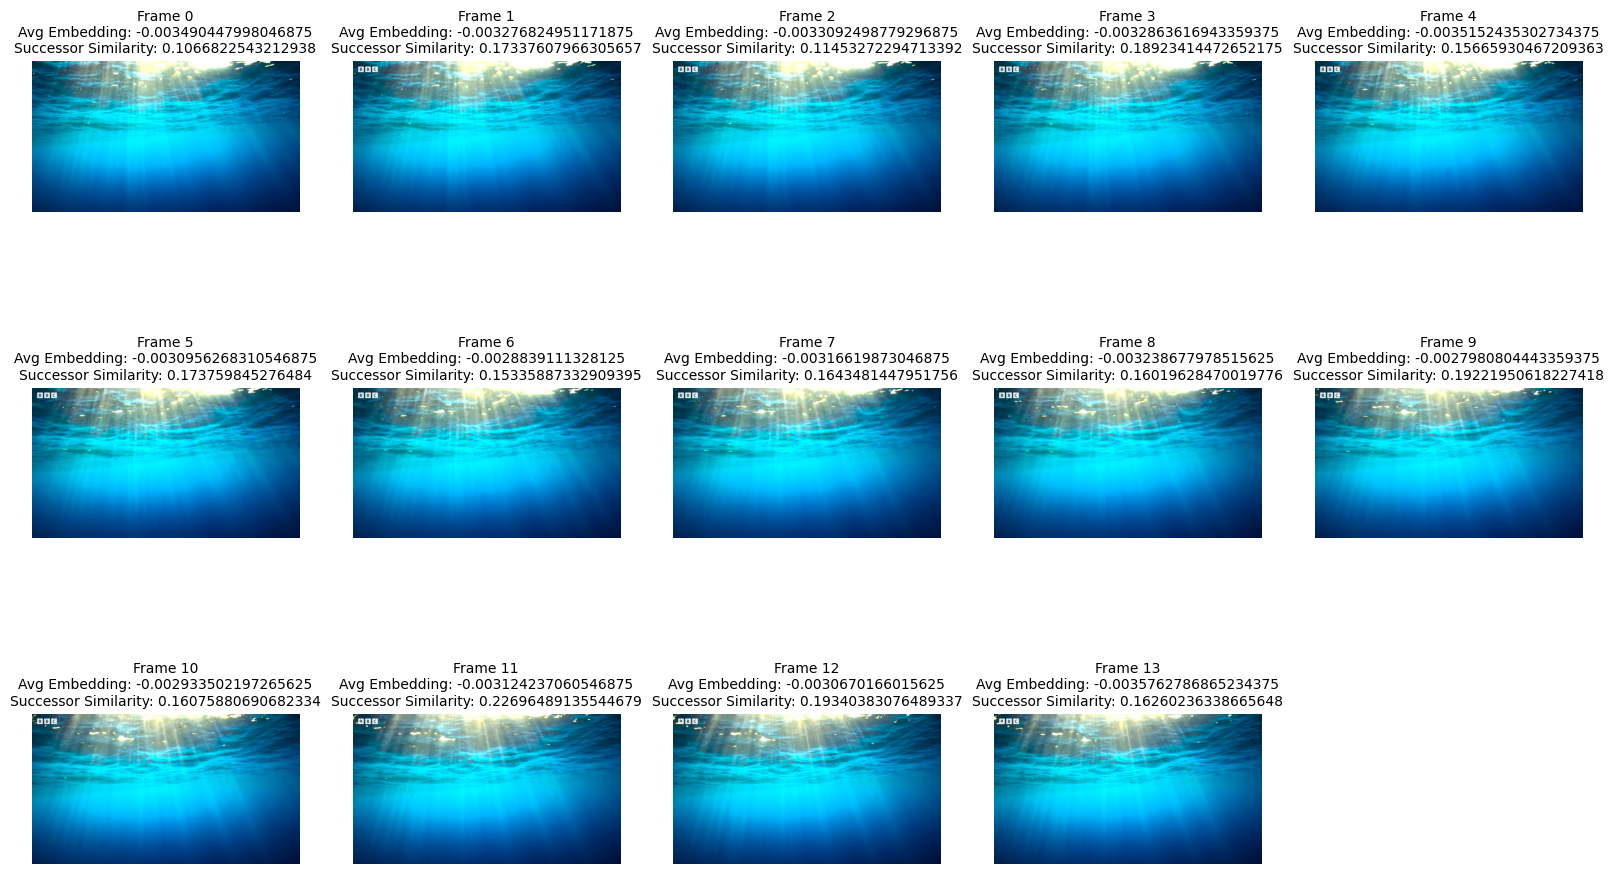

In [4]:
vid_cap = cv2.VideoCapture(video_files[0])
visualize_clips(num_clips=15, vid_cap=vid_cap, embedding_values=segmented_embeddings)

##### Example 2. Processed video keyframes

Potential visual transition at frame 0 with similarity score 0.5212585808515878
Potential visual transition at frame 1 with similarity score 0.8138634397892062
Potential visual transition at frame 2 with similarity score 0.320052481966652
Potential visual transition at frame 3 with similarity score 0.5736972284669689
Potential visual transition at frame 4 with similarity score 0.3163264845872513
Potential visual transition at frame 5 with similarity score 0.6061845053626214
Potential visual transition at frame 6 with similarity score 0.8788248435657163
Potential visual transition at frame 7 with similarity score 0.701454293497693
Potential visual transition at frame 8 with similarity score 0.9220659796986155
Potential visual transition at frame 9 with similarity score 0.573320753406371
Potential visual transition at frame 10 with similarity score 0.6894107425534814
Potential visual transition at frame 11 with similarity score 0.520568720377687
Potential visual transition at frame 12 wi

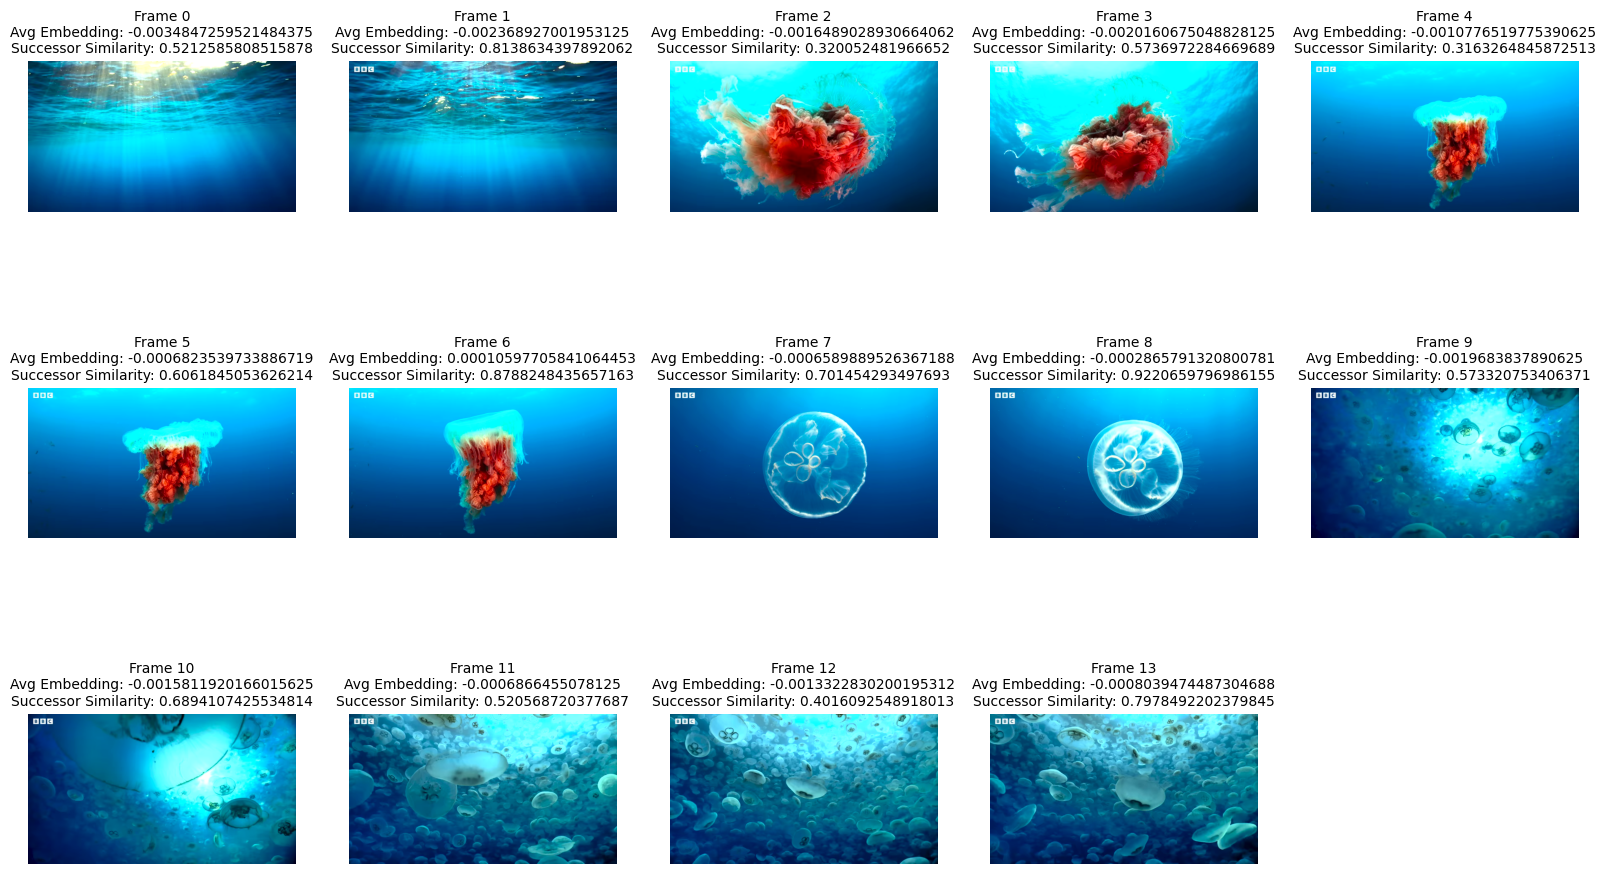

In [3]:
vid_cap = cv2.VideoCapture(key_video_files[0])
visualize_clips(num_clips=15, vid_cap=vid_cap, embedding_values=key_segmented_embeddings)